In [ ]:
# Source: https://github.com/spmallick/PyImageConf2018/blob/master/FaceSwap.ipynb

## Face Blend Function

In [4]:
!wget https://raw.githubusercontent.com/spmallick/PyImageConf2018/master/faceBlendCommon.py

--2020-08-16 11:48:08--  https://raw.githubusercontent.com/spmallick/PyImageConf2018/master/faceBlendCommon.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9546 (9.3K) [text/plain]
Saving to: ‘faceBlendCommon.py.1’

faceBlendCommon.py. 100%[===================>]   9.32K  --.-KB/s    in 0s      

2020-08-16 11:48:08 (101 MB/s) - ‘faceBlendCommon.py.1’ saved [9546/9546]



## 68 Point Dlib Detection Model

In [5]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

--2020-08-16 12:05:04--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  21.7MB/s    in 2.8s    

2020-08-16 12:05:06 (21.7 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



## Import Modules

In [72]:
# Import modules
import sys, cv2,dlib, time
import numpy as np
import faceBlendCommon as fbc
import matplotlib.pyplot as plt

## Read and Display Images

In [103]:
# Read images
img_source = cv2.imread('/content/miley.jpg')
img_target = cv2.imread('/content/Selena-Gomez.jpg')

img_source_display = cv2.cvtColor(img_source, cv2.COLOR_BGR2RGB)
img_target_display = cv2.cvtColor(img_target, cv2.COLOR_BGR2RGB)

img_source_wraped = np.copy(img_target)

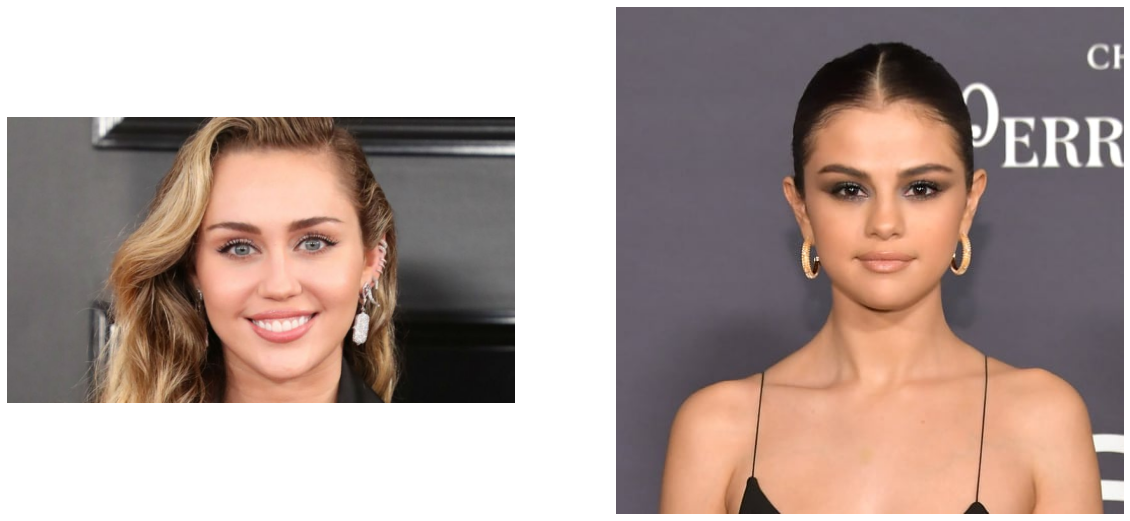

In [104]:
# Display Images 
plt.figure(figsize = (20,10))
plt.subplot(121); plt.imshow(img_source_display); plt.axis('off');
plt.subplot(122); plt.imshow(img_target_display); plt.axis('off');

## Detect Landmarks

In [105]:
# Initialize the dlib facial landmakr detector
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# Read array of corresponding points
points_source = fbc.getLandmarks(detector, predictor, img_source)
points_target = fbc.getLandmarks(detector, predictor, img_target)

## Dispaly Landmarks 

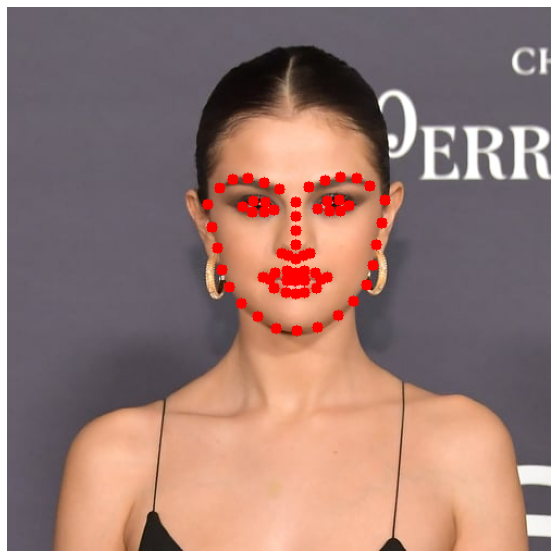

In [106]:
# Display Landmarks
img_temp = img_target_display.copy()
for point in points_target:
    cv2.circle(img_temp, point, 5, (255,0,0), -1)

plt.figure(figsize = (20,10)); plt.imshow(img_temp); plt.axis('off');

## Set Convex Hull

### Create Convex hull

In [107]:
# Find convex hull
hullIndex = cv2.convexHull(np.array(points_target), returnPoints=False)

# Create convex hull lists
hull_source = []
hull_target = []
for i in range(0, len(hullIndex)):
    hull_source.append(points_source[hullIndex[i][0]])
    hull_target.append(points_target[hullIndex[i][0]])

## Display Convex Hull 

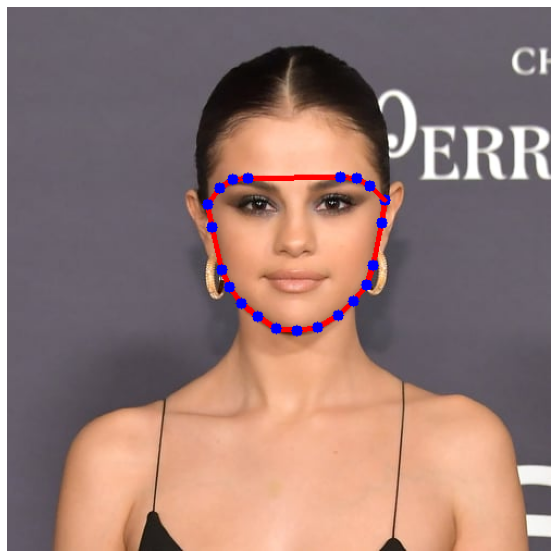

In [108]:
# Display Convex Hull
img_temp = img_target_display.copy()
numPoints = len(hull_target)
for i in range(0, numPoints):
    cv2.line(img_temp, hull_target[i], hull_target[(i+1)%numPoints], (255,0,0), 3)
    cv2.circle(img_temp, hull_target[i], 5, (0,0,255), -1)
plt.figure(figsize = (20,10)); plt.imshow(img_temp); plt.axis('off');

## Get Hull Mask

In [109]:
# Calculate Mask for Seamless cloning
hull8U = []
for i in range(0, len(hull_target)):
    hull8U.append((hull_target[i][0], hull_target[i][1]))

mask = np.zeros(img_target.shape, dtype=img_target.dtype) 
cv2.fillConvexPoly(mask, np.int32(hull8U), (255, 255, 255))

# Find Centroid
m = cv2.moments(mask[:,:,1])
center = (int(m['m10']/m['m00']), int(m['m01']/m['m00']))

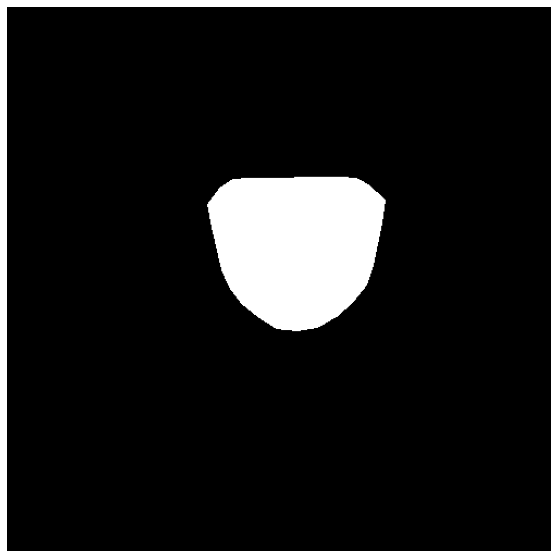

In [110]:
# Display Mask
plt.figure(figsize = (20,10)); plt.imshow(mask); plt.axis('off');

## Create Traingulation

In [111]:
# Find Delaunay traingulation for convex hull points
img_target_size = img_target.shape    
rect = (0, 0, img_target_size[1], img_target_size[0])

dt = fbc.calculateDelaunayTriangles(rect, hull_target)

# If no Delaunay Triangles were found, quit
if len(dt) == 0:
    quit()

In [112]:
img_source_temp = img_source_display.copy()
img_target_temp = img_target_display.copy()

tris_source = []
tris_target = []
for i in range(0, len(dt)):
    tri_source = []
    tri_target = []
    for j in range(0, 3):
        tri_source.append(hull_source[dt[i][j]])
        tri_target.append(hull_target[dt[i][j]])

    tris_source.append(tri_source)
    tris_target.append(tri_target)

cv2.polylines(img_source_temp,np.array(tris_source),True,(0,0,255),2);
cv2.polylines(img_target_temp,np.array(tris_target),True,(0,0,255),2);

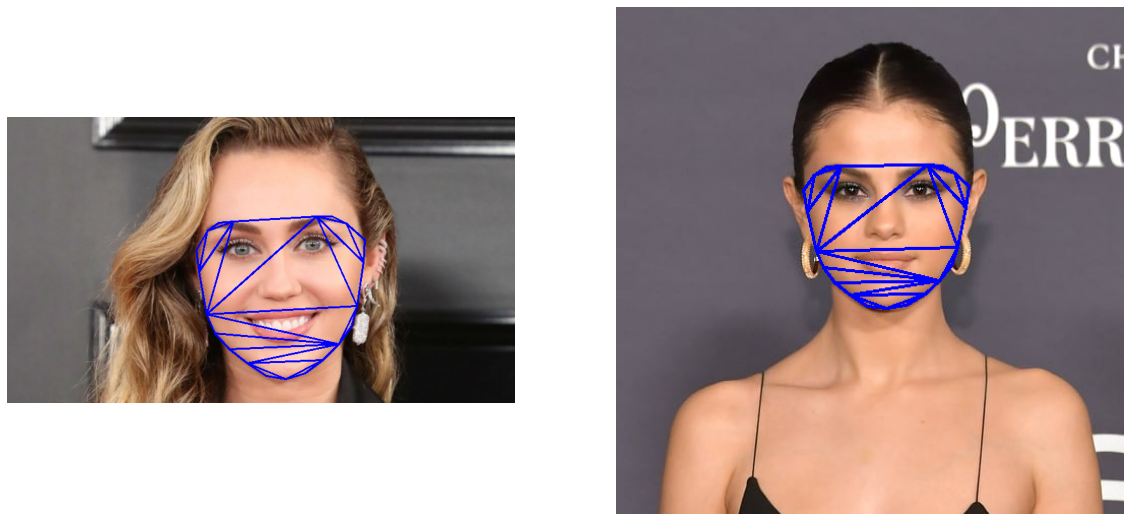

In [113]:
# Display Triangulation
plt.figure(figsize = (20,10)); 
plt.subplot(121); plt.imshow(img_source_temp); plt.axis('off');
plt.subplot(122); plt.imshow(img_target_temp); plt.axis('off');

## Swap Face

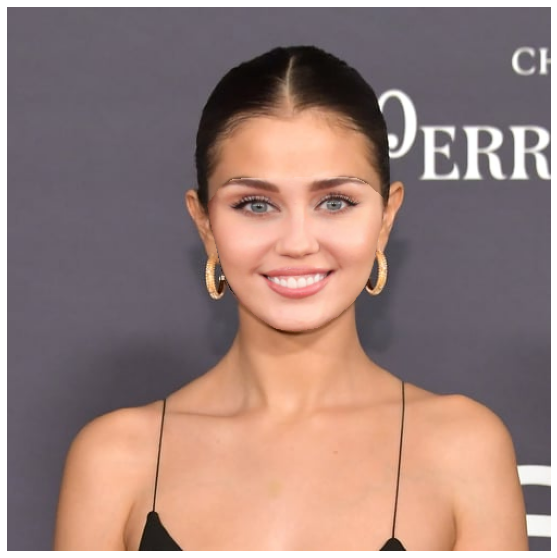

In [114]:
# Simple Alpha Blending
# Apply affine transformation to Delaunay triangles
for i in range(0, len(tris_source)):
    fbc.warpTriangle(img_source, img_source_wraped, tris_source[i], tris_target[i])

plt.figure(figsize=(20,10));
plt.imshow(np.uint8(img_source_wraped)[:,:,::-1]); plt.axis('off');

In [115]:
# Clone seamlessly.
output = cv2.seamlessClone(np.uint8(img_source_wraped), img_target, mask, center, cv2.NORMAL_CLONE)

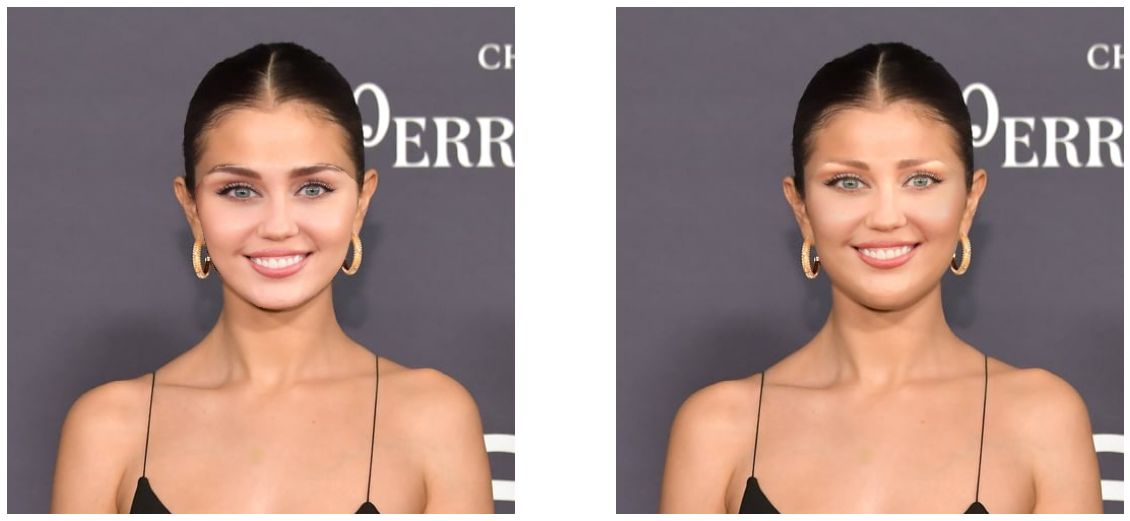

In [116]:
plt.figure(figsize=(20,10))
plt.subplot((121)); plt.imshow(np.uint8(img_source_wraped)[:,:,::-1]); plt.axis('off');
plt.subplot((122)); plt.imshow(output[:,:,::-1]); plt.axis('off');

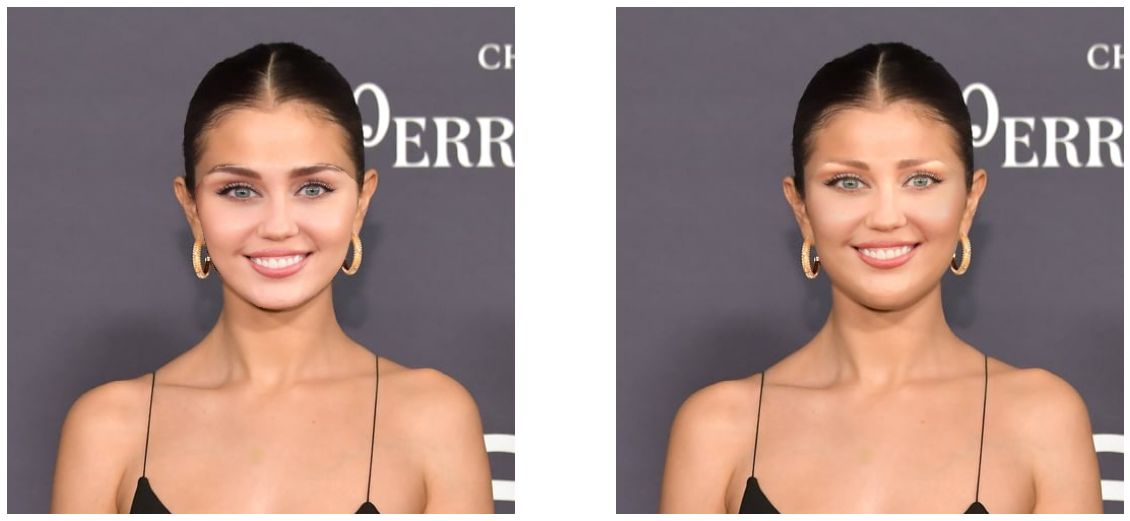

In [117]:
plt.figure(figsize=(20,10))
plt.subplot((121)); plt.imshow(np.uint8(img_source_wraped)[:,:,::-1]); plt.axis('off');
plt.subplot((122)); plt.imshow(output[:,:,::-1]); plt.axis('off');